<a href="https://colab.research.google.com/github/kokysilva/hello_world/blob/master/Laboratorio1_Nanez_Gomez_Jose_Francisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1:Convolutional Neural Networks

**Maestría:** Maestría en Inteligencia Artificial

**Materia:** Sistemas Cognitivos

**Presentado por:** José Ñáñez, Jorge Silva, Ricardo Prieto, Albert Velastegui

**Fecha:** 2018-10-29

**Lenguaje:** Python

**Versión:** 3.7

**Plataforma:** Google Colaboratory



### Descripción

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob
import random
import warnings

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
import pandas as pd


In [0]:
warnings.filterwarnings('ignore')

# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [0]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

print ("Lectura de imagenes")

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Lectura de imagenes
Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [0]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## **0. Planteamiento de la solución**

A continuación se presenta el desarrollo de la solución al problema planteado:


![texto alternativo](https://upload.wikimedia.org/wikipedia/en/0/0d/Simpsons_FamilyPicture.png)


**Pasos**

*Descarga de los datos de entrenamiento [link de descarga](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60)

*Descarga de los datos de test [link de descarga](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8)

* Preprocesar la data: ajuste de tamaño, reescalamiento, conversión de labels y división de la data en data de entrenamiento y data de prueba

* Construcción del modelo

* Adición de dropout layer, teniendo en cuenta el overfitting

* Verificación del modelo original y re-entrenamiento del modelo, para encontrar la mejor solución

* Predicción y selección de la mejor solución.

**Descripción de la data*

*Estructura: 20 carpetas de imagenes
*Personas: Por cada personaje hay una carpeta de entrenamiento
*Cantidad de imágenes por cada carpeta: De 400 a 2000 imágenes en cada carpeta
*Carpeta de trenes de imágenes: Una con 990 imágenes etiquetadas
*Redimencionamiento: El redimencionamiento de cada imagén será a 64x64 pixeles

# **1. Información del dataset**

Una vez tenemos los datos cargados en memoria, vamos a obtener información sobre los mismos.


In [0]:
print('Cantidad de imágenes de entrenamiento X y Y: ', X.shape, y.shape)
print('Cantidad de imágenes de prueba X_t y Y_t: ', X_t.shape, y_t.shape)

Cantidad de imágenes de entrenamiento X y Y:  (18992, 64, 64, 3) (18992,)
Cantidad de imágenes de prueba X_t y Y_t:  (890, 64, 64, 3) (890,)


Como se observa en el código anteriormene, los arreglos están compuestos por:  
1. X:     18.992 imágenes con un tamaño de 64x64  
2. X_t:       890 imágenes con un tamaño de 64x64  


In [0]:
#Caracteristicas de los dataset's
print("Enternamiento -  rows:",X.shape[0]," columns:", y.shape[0])
print("Pruebas -  rows:",X_t.shape[0]," columns:", y_t.shape[0])


Enternamiento -  rows: 18992  columns: 18992
Pruebas -  rows: 890  columns: 890


# **2. Normalización de los datos data**

Normalizamos los datos de manera similar a como hemos visto con MNIST. Este paso es muy importante para el correcto funcionamiento de nuestra red.

In [0]:
# Normalización de los datos
print("Ejecución del proceso de normalización de la data")
X = X.astype('float32')
X_t = X_t.astype('float32')
X_train  =  X/255.0 
X_test  =  X_t/255.0
Y_train = y
Y_test  =  y_t
print("Data normalizada")

Ejecución del proceso de normalización de la data
Data normalizada


# 3. **Etiquetado de los datos**

In [0]:
#Codificar etiquetas en vectores (ej: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train_cod = to_categorical(Y_train, num_classes = 20)
Y_test_cod = to_categorical(Y_test, num_classes = 20)

# Display the change for category label using one-hot encoding
print('Eitquetado original:', Y_train[0])
print('Después de la conversión:', Y_train_cod[0])

Eitquetado original: 3
Después de la conversión: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# **4. Visualización de las imágenes**

A continuación se presenta un conjunto de figuras del set de datos; iniciando en la figura 50 y terminando en la figura 75, esto para no tomar las primeras figuras del set de datos.


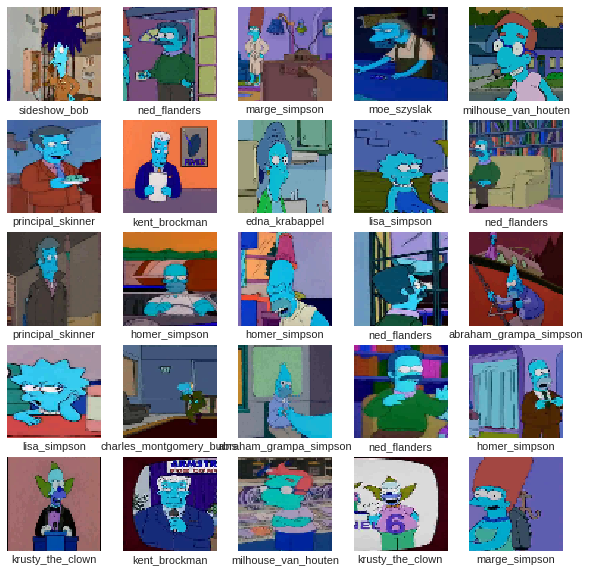

In [0]:
plt.figure(figsize=(10,10))
for i in range(50, 75):
    plt.subplot(5,5,(i-50)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(MAP_CHARACTERS[Y_train[i]])

# **5. Red neuronal**

Las imagenes tienen un tamaño de 64x64, se normalizo las imágenes. Se utilizará un conjunto de tres capas de redes neuronales:



1.   La primera capa tendrá un filtro de 32 (2^5) y un kernel de 3x3
2.   La segunda capa tendrá un filtro de 64 (2^6) y un kernel de 3x3
3.   La tercera capa tendrá un filtro de 128 (2^7) y un kernel de 3x3
4.   La selección de la máxima intensidad por zona será de 2x2
5.   El número de clases será de 20
6.   El número de epocas será de 20
7.   La activación es de tipo relu, debido a que provee mejor efectividad que la función de sigmoid 
8.   La última capa es de tipo Dense, con una activación softmax y un num_class



## **5.1. Definir el modelo**


### **5.1.1 Función para plotear el resultado**

In [0]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

### **5.1.2. Función donde se define la red**

In [0]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

def function_convolutional_network(X_train, Y_train_cod, epochs, BATCH_SIZE, NUM_CLASS, lr, decay, LAYER_SIZE, dropout):

  print("Pasos:")
  print("1. Construcción del modelo")
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',  activation ='relu', input_shape = (64,64,3)))
  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',  activation ='relu'))
  #Selección de la máxima intensidad en una zona de 2x2
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  
  for i in range(1, len(LAYER_SIZE)):
    model.add(Conv2D(filters = LAYER_SIZE[i], kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = LAYER_SIZE[i], kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #Selección de la máxima intensidad en una zona de 2x2
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    

  model.add(Flatten())
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASS, activation = "softmax"))
  
  print("2. Optimización")
  optimizer = RMSprop(lr=lr, decay=decay)

  print("3. Compilación")
  model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

  print("4. Entrenamiento")        
  history=model.fit(X_train, Y_train_cod, epochs=epochs,batch_size=BATCH_SIZE)
  
  print("5. Visualización del resultado")
  score = model.evaluate(X_test, Y_test_cod, verbose=0)
  print('Loss', score[0])
  print('Accuracy:', score[1])

  plot_history(history)
  
  return score

### **5.1.3 Definición de variables base**

A continuación se define una función que permite construir iteraciones, donde en cada iteración se tendrán valores fijos (Constantes) y valores variables.

#### Constantes:
*  LAYER_SIZE = [32,64,128]
*  BATCH_SIZE=64
*  NUM_CLASS=20
  
#### Variables:
dropout = rango de 0.2 a 0.5
lr = rango de 0.001 a 0.002
decay = rango de 1e-5 a 1e-6
epocas = 10 a 20

 

In [0]:
# Variables
def function_best_parameters(INTERATIONS):
  
  #Constantes
  LAYER_SIZE = [32,64,128]
  BATCH_SIZE=64
  NUM_CLASS=20
  
  #Dataframe donde se almacenará la información de todas las corridas
  columns = ['dropout','lr', 'decay', 'epochs', 'Loss', 'Accuracy']
  df = pd.DataFrame(columns=columns, dtype=float)

  for i in range(INTERATIONS):
    print("*************************************************************************************************")
    print("*************************************************************************************************")
    print("Interación: ", i+1)

    #dropout=0.2
    dropout=random.uniform(0.2, 0.5)
    
    #Tasa de aprendizaje
    lr=random.uniform(0.001, 0.002)
    
    #Tasa de deterioro
    decay=random.uniform(1e-5,1e-6) 
    
    #Epocas
    epochs=random.randint(10,20)

    score = function_convolutional_network(X_train, Y_train_cod, epochs, BATCH_SIZE, NUM_CLASS, lr, decay, LAYER_SIZE, dropout)
    
    df = df.append({'dropout':dropout,'lr':lr, 'decay':decay, 'epochs':epochs, 'Loss':score[0], 'Accuracy':score[1]}, ignore_index=True)
  
  
  
  return df

### **5.1.4 Ejecución del modelo**

*************************************************************************************************
*************************************************************************************************
Interación:  1
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/13
18992/18992 [==============================] - 26s 1ms/step - loss: 2.4391 - acc: 0.3256
Epoch 2/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.5487 - acc: 0.5514
Epoch 3/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2067 - acc: 0.6500
Epoch 4/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0443 - acc: 0.7009
Epoch 5/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9281 - acc: 0.7367
Epoch 6/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8503 - acc: 0.7650
Epoch 7/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7778 - acc: 0.7837
Epoch 8

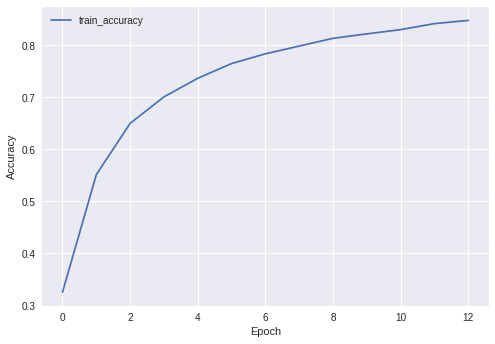

*************************************************************************************************
*************************************************************************************************
Interación:  2
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/18
18992/18992 [==============================] - 26s 1ms/step - loss: 2.3144 - acc: 0.3773
Epoch 2/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2802 - acc: 0.6274
Epoch 3/18
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9560 - acc: 0.7287
Epoch 4/18
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8122 - acc: 0.7755
Epoch 5/18
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7153 - acc: 0.8040
Epoch 6/18
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6508 - acc: 0.8238
Epoch 7/18
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6050 - acc: 0.8435
Epoch 8

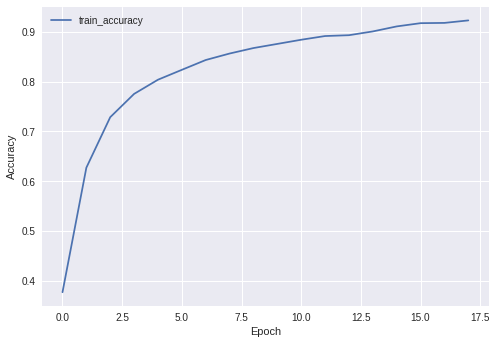

*************************************************************************************************
*************************************************************************************************
Interación:  3
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/16
18992/18992 [==============================] - 27s 1ms/step - loss: 2.3078 - acc: 0.3606
Epoch 2/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3583 - acc: 0.6073
Epoch 3/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0261 - acc: 0.7029
Epoch 4/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8633 - acc: 0.7558
Epoch 5/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7731 - acc: 0.7889
Epoch 6/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6889 - acc: 0.8128
Epoch 7/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6126 - acc: 0.8336
Epoch 8

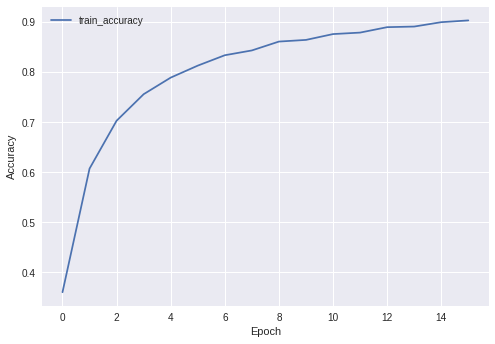

*************************************************************************************************
*************************************************************************************************
Interación:  4
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/11
18992/18992 [==============================] - 27s 1ms/step - loss: 2.8227 - acc: 0.2769
Epoch 2/11
18992/18992 [==============================] - 20s 1ms/step - loss: 1.5919 - acc: 0.5292
Epoch 3/11
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2505 - acc: 0.6351
Epoch 4/11
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0864 - acc: 0.6888
Epoch 5/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9306 - acc: 0.7359
Epoch 6/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8763 - acc: 0.7617
Epoch 7/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8151 - acc: 0.7796
Epoch 8

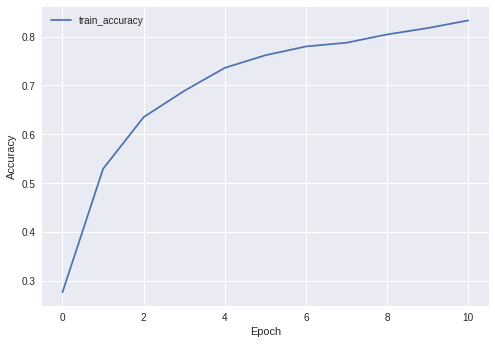

*************************************************************************************************
*************************************************************************************************
Interación:  5
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/20
18992/18992 [==============================] - 27s 1ms/step - loss: 2.3181 - acc: 0.3837
Epoch 2/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3081 - acc: 0.6186
Epoch 3/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9878 - acc: 0.7170
Epoch 4/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8050 - acc: 0.7715
Epoch 5/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7015 - acc: 0.8051
Epoch 6/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6099 - acc: 0.8309
Epoch 7/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.5618 - acc: 0.8449
Epoch 8

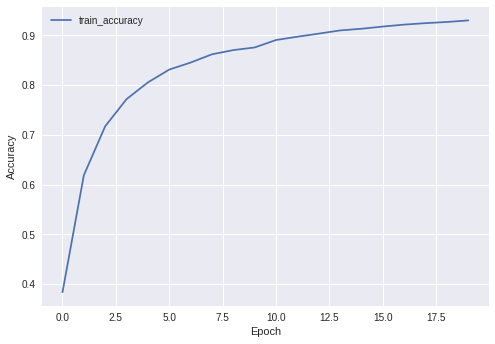

*************************************************************************************************
*************************************************************************************************
Interación:  6
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/20
18992/18992 [==============================] - 28s 1ms/step - loss: 2.4367 - acc: 0.3808
Epoch 2/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2770 - acc: 0.6304
Epoch 3/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9731 - acc: 0.7209
Epoch 4/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8379 - acc: 0.7676
Epoch 5/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7259 - acc: 0.8026
Epoch 6/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6717 - acc: 0.8181
Epoch 7/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6058 - acc: 0.8375
Epoch 8

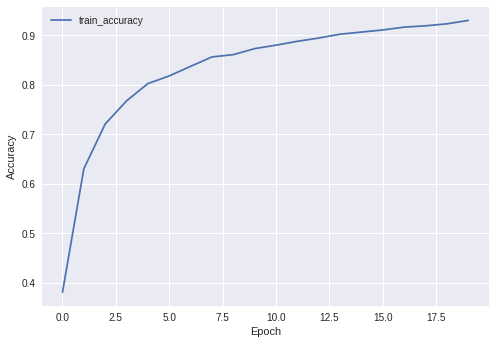

*************************************************************************************************
*************************************************************************************************
Interación:  7
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/14
18992/18992 [==============================] - 28s 1ms/step - loss: 2.3329 - acc: 0.3571
Epoch 2/14
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4319 - acc: 0.5862
Epoch 3/14
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0991 - acc: 0.6848
Epoch 4/14
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9558 - acc: 0.7287
Epoch 5/14
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8368 - acc: 0.7631
Epoch 6/14
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7635 - acc: 0.7880
Epoch 7/14
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7108 - acc: 0.8064
Epoch 8

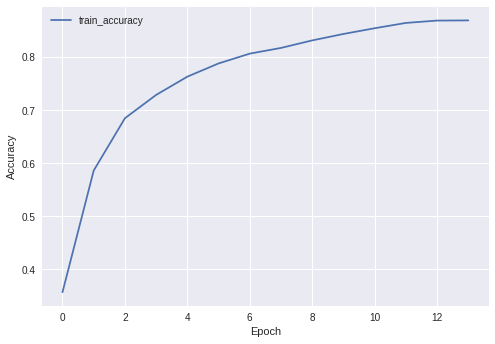

*************************************************************************************************
*************************************************************************************************
Interación:  8
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/12
18992/18992 [==============================] - 28s 1ms/step - loss: 2.4962 - acc: 0.3647
Epoch 2/12
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4276 - acc: 0.5825
Epoch 3/12
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0990 - acc: 0.6814
Epoch 4/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9589 - acc: 0.7311
Epoch 5/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8361 - acc: 0.7685
Epoch 6/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7564 - acc: 0.7942
Epoch 7/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6831 - acc: 0.8163
Epoch 8

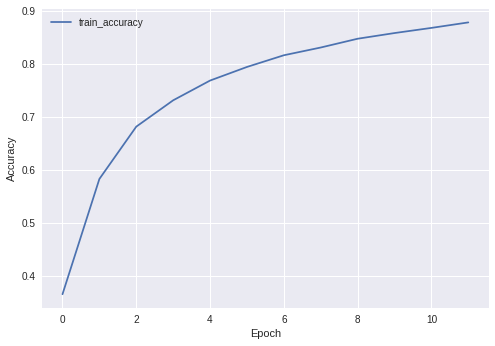

*************************************************************************************************
*************************************************************************************************
Interación:  9
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/15
18992/18992 [==============================] - 28s 1ms/step - loss: 2.4037 - acc: 0.3477
Epoch 2/15
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4880 - acc: 0.5674
Epoch 3/15
18992/18992 [==============================] - 19s 1ms/step - loss: 1.1659 - acc: 0.6628
Epoch 4/15
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0092 - acc: 0.7132
Epoch 5/15
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8775 - acc: 0.7498
Epoch 6/15
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8127 - acc: 0.7747
Epoch 7/15
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7471 - acc: 0.7928
Epoch 8

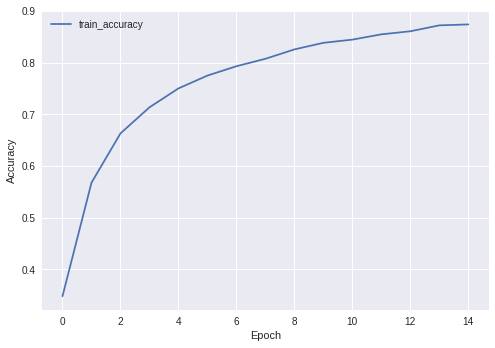

*************************************************************************************************
*************************************************************************************************
Interación:  10
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/11
18992/18992 [==============================] - 29s 2ms/step - loss: 2.2662 - acc: 0.3828
Epoch 2/11
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3332 - acc: 0.6130
Epoch 3/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9923 - acc: 0.7165
Epoch 4/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7933 - acc: 0.7785
Epoch 5/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7136 - acc: 0.8076
Epoch 6/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6401 - acc: 0.8284
Epoch 7/11
18992/18992 [==============================] - 19s 1ms/step - loss: 0.5989 - acc: 0.8423
Epoch 

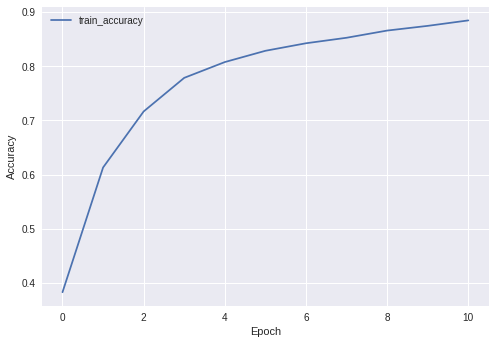

*************************************************************************************************
*************************************************************************************************
Interación:  11
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/13
18992/18992 [==============================] - 29s 2ms/step - loss: 2.5831 - acc: 0.3197
Epoch 2/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4568 - acc: 0.5754
Epoch 3/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1410 - acc: 0.6771
Epoch 4/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9446 - acc: 0.7340
Epoch 5/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8353 - acc: 0.7680
Epoch 6/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7390 - acc: 0.7965
Epoch 7/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6885 - acc: 0.8142
Epoch 

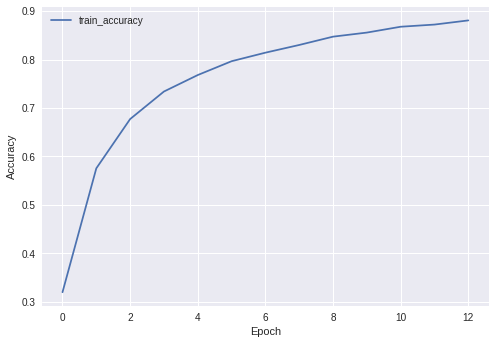

*************************************************************************************************
*************************************************************************************************
Interación:  12
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/20
18992/18992 [==============================] - 30s 2ms/step - loss: 2.6916 - acc: 0.2816
Epoch 2/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.7371 - acc: 0.4857
Epoch 3/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4329 - acc: 0.5815
Epoch 4/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2807 - acc: 0.6305
Epoch 5/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1527 - acc: 0.6728
Epoch 6/20
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0543 - acc: 0.7051
Epoch 7/20
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9808 - acc: 0.7237
Epoch 

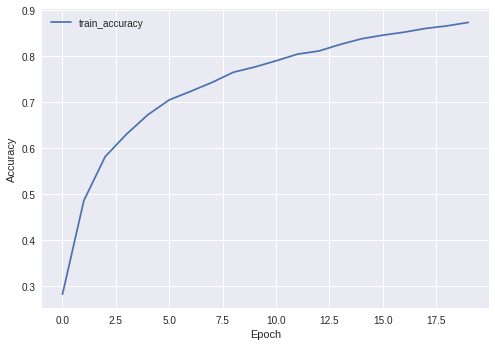

*************************************************************************************************
*************************************************************************************************
Interación:  13
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/19
18992/18992 [==============================] - 30s 2ms/step - loss: 2.5705 - acc: 0.3098
Epoch 2/19
18992/18992 [==============================] - 20s 1ms/step - loss: 1.6448 - acc: 0.5250
Epoch 3/19
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3561 - acc: 0.6139
Epoch 4/19
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1718 - acc: 0.6656
Epoch 5/19
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0514 - acc: 0.7070
Epoch 6/19
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9989 - acc: 0.7268
Epoch 7/19
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9171 - acc: 0.7488
Epoch 

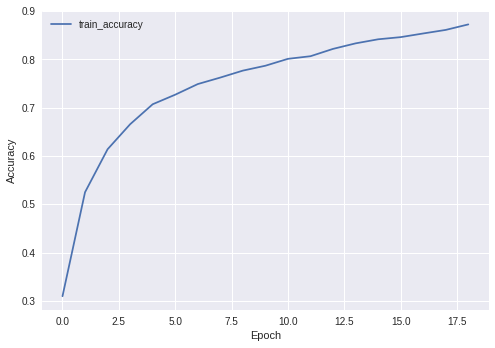

*************************************************************************************************
*************************************************************************************************
Interación:  14
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/15
18992/18992 [==============================] - 31s 2ms/step - loss: 2.5538 - acc: 0.3314
Epoch 2/15
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4667 - acc: 0.5747
Epoch 3/15
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1603 - acc: 0.6692
Epoch 4/15
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0107 - acc: 0.7169
Epoch 5/15
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9119 - acc: 0.7493
Epoch 6/15
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8280 - acc: 0.7729
Epoch 7/15
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7606 - acc: 0.7957
Epoch 

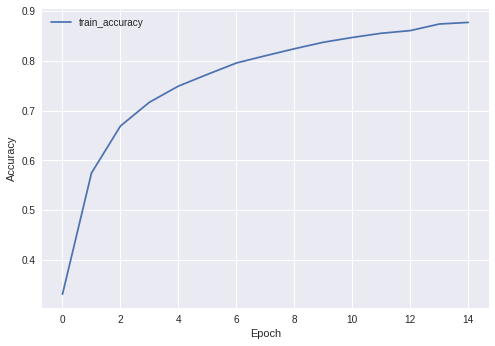

*************************************************************************************************
*************************************************************************************************
Interación:  15
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/12
18992/18992 [==============================] - 31s 2ms/step - loss: 2.5296 - acc: 0.3383
Epoch 2/12
18992/18992 [==============================] - 20s 1ms/step - loss: 1.5207 - acc: 0.5527
Epoch 3/12
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2074 - acc: 0.6482
Epoch 4/12
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0181 - acc: 0.7085
Epoch 5/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8718 - acc: 0.7536
Epoch 6/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7977 - acc: 0.7763
Epoch 7/12
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7500 - acc: 0.7961
Epoch 

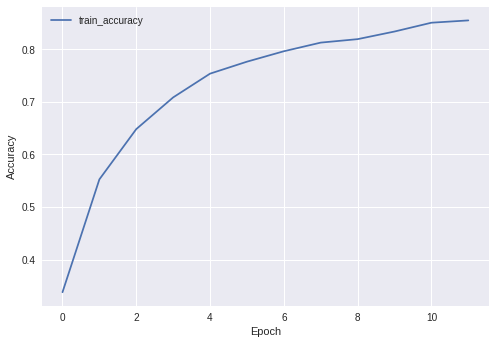

*************************************************************************************************
*************************************************************************************************
Interación:  16
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/11
18992/18992 [==============================] - 31s 2ms/step - loss: 2.4522 - acc: 0.3424
Epoch 2/11
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4403 - acc: 0.5789
Epoch 3/11
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1135 - acc: 0.6814
Epoch 4/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9535 - acc: 0.7307
Epoch 5/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8529 - acc: 0.7612
Epoch 6/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7992 - acc: 0.7822
Epoch 7/11
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7219 - acc: 0.8023
Epoch 

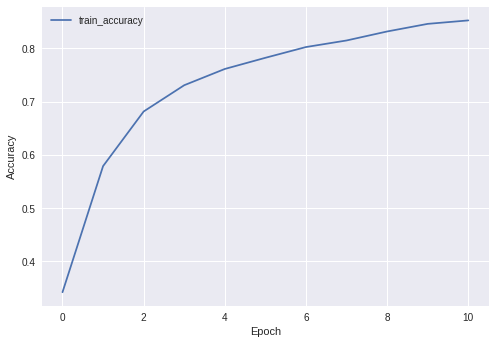

*************************************************************************************************
*************************************************************************************************
Interación:  17
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/16
18992/18992 [==============================] - 31s 2ms/step - loss: 2.6544 - acc: 0.2912
Epoch 2/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.7614 - acc: 0.4834
Epoch 3/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4982 - acc: 0.5690
Epoch 4/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3365 - acc: 0.6173
Epoch 5/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2277 - acc: 0.6525
Epoch 6/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1486 - acc: 0.6809
Epoch 7/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0520 - acc: 0.7053
Epoch 

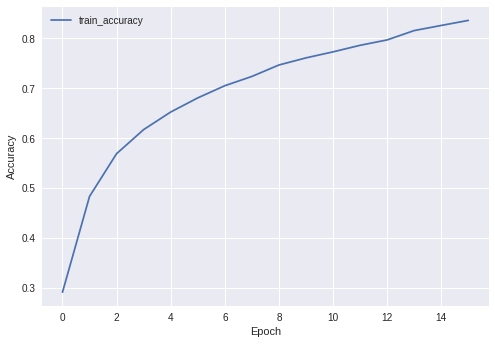

*************************************************************************************************
*************************************************************************************************
Interación:  18
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/13
18992/18992 [==============================] - 31s 2ms/step - loss: 2.9933 - acc: 0.2990
Epoch 2/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.4410 - acc: 0.5798
Epoch 3/13
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1441 - acc: 0.6727
Epoch 4/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9693 - acc: 0.7296
Epoch 5/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8368 - acc: 0.7710
Epoch 6/13
18992/18992 [==============================] - 19s 1ms/step - loss: 0.7636 - acc: 0.7945
Epoch 7/13
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7156 - acc: 0.8101
Epoch 

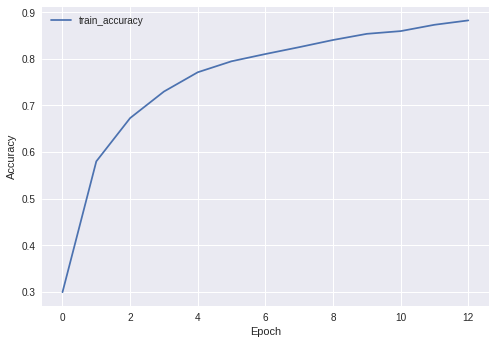

*************************************************************************************************
*************************************************************************************************
Interación:  19
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/16
18992/18992 [==============================] - 31s 2ms/step - loss: 2.3986 - acc: 0.3492
Epoch 2/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3749 - acc: 0.6006
Epoch 3/16
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0728 - acc: 0.6880
Epoch 4/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.9201 - acc: 0.7450
Epoch 5/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.8296 - acc: 0.7724
Epoch 6/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.7707 - acc: 0.7924
Epoch 7/16
18992/18992 [==============================] - 20s 1ms/step - loss: 0.6985 - acc: 0.8134
Epoch 

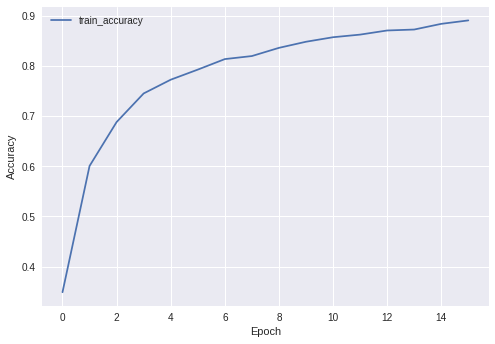

*************************************************************************************************
*************************************************************************************************
Interación:  20
Pasos:
1. Construcción del modelo
2. Optimización
3. Compilación
4. Entrenamiento
Epoch 1/18
18992/18992 [==============================] - 32s 2ms/step - loss: 2.6526 - acc: 0.2878
Epoch 2/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.7727 - acc: 0.4776
Epoch 3/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.5053 - acc: 0.5624
Epoch 4/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.3238 - acc: 0.6171
Epoch 5/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.2150 - acc: 0.6576
Epoch 6/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.1525 - acc: 0.6803
Epoch 7/18
18992/18992 [==============================] - 20s 1ms/step - loss: 1.0717 - acc: 0.7029
Epoch 

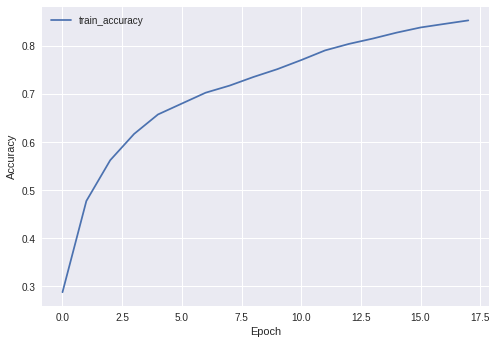



*************************************************************************************************
*************************************************************************************************
Dataframe de resultados de los modelos ejecutados
     dropout        lr     decay  epochs      Loss  Accuracy
0   0.382050  0.001312  0.000008    13.0  0.697907  0.843820
1   0.247067  0.001458  0.000010    18.0  0.188872  0.948315
2   0.322271  0.001141  0.000002    16.0  0.187617  0.944944
3   0.347443  0.001888  0.000002    11.0  0.478741  0.865169
4   0.283154  0.001127  0.000008    20.0  0.104736  0.967416
5   0.228339  0.001648  0.000007    20.0  0.439611  0.911236
6   0.367290  0.001233  0.000004    14.0  0.244714  0.917978
7   0.225261  0.001846  0.000005    12.0  1.911208  0.788764
8   0.378061  0.001328  0.000003    15.0  0.538011  0.846067
9   0.343046  0.001003  0.000009    11.0  0.403421  0.885393
10  0.246046  0.001882  0.000004    13.0  0.386519  0.917978
11  0.480759  0.0018

In [0]:
df_results = function_best_parameters(20)

print("\n\n*************************************************************************************************")
print("*************************************************************************************************")
print("Dataframe de resultados de los modelos ejecutados")
print(df_results)

*texto en cursiva*### **5.1.6 Resulatdos**

De los resultados obtenidos se puede realizar un procesamiento posterior, buscando el mejor Accuracy con el menor número de Epocas, con el fin de encontrar el conjunto de soluciones que generen el menor grado de overfitting.

A continuación se presentan los resultados 


1.   List item
2.   List item



Dataframe de resultados de los modelos ejecutados


| index     | dropout         |        lr           |   decay        |epochs   |   Loss            |  Accuracy      |
|--------------|:---------------------|:------------------|:------------------|:--------------|--------------------:|---------------------:|
| 0  | 0.382050    | 0.001312  | 0.000008   |  13.0 | 0.697907 |  0.843820 |
| 1  | 0.247067    | 0.001458  | 0.000010   |  18.0 | 0.188872 |  0.948315 | 
| 2  | 0.322271    | 0.001141  | 0.000002   |  16.0 | 0.187617 |  0.944944 | 
| 3  | 0.347443    | 0.001888  | 0.000002   |  11.0 | 0.478741 |  0.865169 | 
| 4  | 0.283154    | 0.001127  | 0.000008   |  20.0 | 0.104736 | 0.967416  | 
| 5  | 0.228339    | 0.001648  | 0.000007   |  20.0 | 0.439611 | 0.911236  | 
| 6  | 0.367290    | 0.001233  | 0.000004   |  14.0 | 0.244714 | 0.917978  | 
| 7   | 0.225261  | 0.001846  | 0.000005   |  12.0 |  1.911208  | 0.788764 | 
| 8   | 0.378061  | 0.001328  | 0.000003   |  15.0 |  0.538011  | 0.846067 | 
| 9   | 0.343046  | 0.001003  | 0.000009   |  11.0 |  0.403421  | 0.885393 | 
| 10 |  0.246046 |  0.001882 |  0.000004  |  13.0 |  0.386519  | 0.917978 | 
| 11 |  0.480759 |  0.001819 |  0.000007  |   20.0 |  0.226102 |  0.940449 | 
| 12 |  0.441690 | 0.001624  | 0.000005   |  19.0  | 1.346811  | 0.828090 | 
| 13 | 0.322403  | 0.001930  | 0.000009   |  15.0  | 0.353281  | 0.910112 | 
| 14 | 0.310283  | 0.001695  | 0.000007   |  12.0  | 0.484462  | 0.869663  | 
| 15 |  0.311951 | 0.001602  | 0.000004   |  11.0  | 0.593107  | 0.858427 | 
| 16 |  0.478628 | 0.001822  | 0.000010   |  16.0  | 0.489157  | 0.868539 | 
| 17 |  0.230381 | 0.001907  | 0.000009   |  13.0  | 0.460383  | 0.915730 | 
| 18 |  0.350256 | 0.001333  | 0.000006   |  16.0  | 0.305937  | 0.919101 | 
| 19 |  0.493728 | 0.001852  | 0.000010   |  18.0  | 0.241207  | 0.920225 | 

De los resultados extraemos:

| index     | dropout         |        lr           |   decay        |epochs   |   Loss            |  Accuracy      |
|--------------|:---------------------|:------------------|:------------------|:--------------|--------------------:|---------------------:|
| 5  | 0.228339    | 0.001648  | 0.000007   |  20.0 | 0.439611 | 0.911236  | 
| 6  | 0.367290    | 0.001233  | 0.000004   |  14.0 | 0.244714 | 0.917978  | 
| 10 |  0.246046 |  0.001882 |  0.000004  |  13.0 |  0.386519  | 0.917978 | 
| 13 | 0.322403  | 0.001930  | 0.000009   |  15.0  | 0.353281  | 0.910112 | 
| 17 |  0.230381 | 0.001907  | 0.000009   |  13.0  | 0.460383  | 0.915730 | 
| 18 |  0.350256 | 0.001333  | 0.000006   |  16.0  | 0.305937  | 0.919101 | 

Estos son las iteraciones que no obtienen un porcentaje de efectividad superior al 92%, con el fin de garantizar que no se genere overfitting. De los seis seleccionamos el que menor número de epocas y Loss tenga, el resultado es:

| index     | dropout         |        lr           |   decay        |epochs   |   Loss            |  Accuracy      |
|--------------|:---------------------|:------------------|:------------------|:--------------|--------------------:|---------------------:|
| 10 |  0.246046 |  0.001882 |  0.000004  |  13.0 |  0.386519  | 0.917978 | 


Gracias

# 6. Conclusiones


In [0]:
accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar. -> **Crear un perfilamiento**
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc. -> Prueba de parámetros (automatizar)
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.
# **bold text**
Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.